# Adult Dataset — Preprocessing, Feature Engineering & Feature Selection
This notebook covers:
- **Data exploration & preprocessing**
- **Scaling** (Standard & Min-Max) with when-to-use guidance
- **Encoding**: One-Hot (<5 categories) & Label Encoding (≥5 categories)
- **Feature engineering** (at least 2 new features)
- **Transformation** for skewed features
- **Feature selection** via **Isolation Forest** and **PPS** vs **Correlation**


In [11]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ppscore as pps

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest

pd.set_option('display.max_columns', 100)

## 1) Load & Inspect Data

In [2]:
# Load the Adult dataset (with headers)
df = pd.read_csv('adult_with_headers.csv')

print("Shape:", df.shape)
display(df.head())
display(df.tail(3))

print("\nDtypes:")
display(df.dtypes)

print("\nMissing values (raw):")
display(df.isna().sum())

# Convert '?' placeholders to NaN
df = df.replace('?', np.nan)

print("\nMissing values (after '?' -> NaN):")
display(df.isna().sum())

Shape: (32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K



Dtypes:


age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object


Missing values (raw):


age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


Missing values (after '?' -> NaN):


age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

### Summary statistics

In [3]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

display(df[numeric_cols].describe())
display(df[categorical_cols].describe(include='all'))

Numeric columns: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical columns: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


### Quick EDA Plots (Matplotlib)

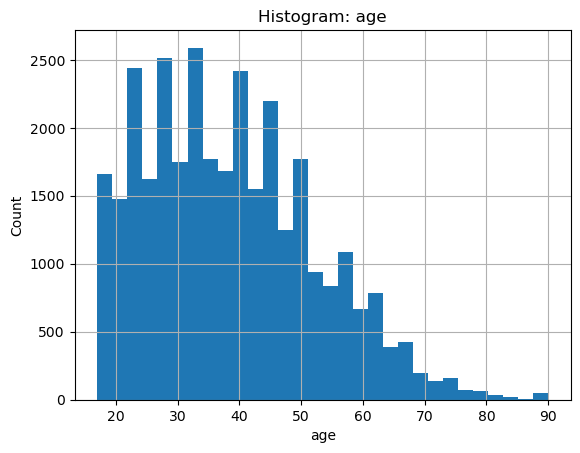

In [4]:
# Select common numeric columns if available
candidates = [c for c in ['age','hours-per-week','capital-gain','capital-loss','education-num'] if c in df.columns]

for col in candidates:
    plt.figure()
    df[col].dropna().hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Correlation among numeric
if len(candidates) >= 2:
    corr = df[candidates].corr()
    plt.figure()
    plt.imshow(corr, interpolation='nearest')
    plt.title("Correlation Matrix (Selected numeric features)")
    plt.colorbar()
    plt.xticks(range(len(candidates)), candidates, rotation=90)
    plt.yticks(range(len(candidates)), candidates)
    plt.tight_layout()
    plt.show()

## 2) Preprocessing — Handle Missing Values

In [5]:
# Impute numeric with median; categorical with mode
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df_num = pd.DataFrame(num_imputer.fit_transform(df.select_dtypes(include=[np.number])),
                      columns=df.select_dtypes(include=[np.number]).columns, index=df.index)
df_cat = pd.DataFrame(cat_imputer.fit_transform(df.select_dtypes(exclude=[np.number])),
                      columns=df.select_dtypes(exclude=[np.number]).columns, index=df.index)

df_clean = pd.concat([df_num, df_cat], axis=1)
display(df_clean.isna().sum())

age               0
fnlwgt            0
education_num     0
capital_gain      0
capital_loss      0
hours_per_week    0
workclass         0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
native_country    0
income            0
dtype: int64

## 3) Scaling (Standard vs Min-Max)
**When to use which?**
- **StandardScaler**: zero-mean/unit-variance; good for models assuming standardized inputs or using dot-products (Linear/Logistic Regression, SVM, PCA).
- **MinMaxScaler**: scales to [0,1]; preserves relative distances and bounded features; useful for Neural Nets or when absolute bounds matter.

In [6]:
numeric_cols = df_num.columns.tolist()

std_scaler = StandardScaler()
mm_scaler  = MinMaxScaler()

X_std = pd.DataFrame(std_scaler.fit_transform(df_clean[numeric_cols]),
                     columns=[f"{c}_std" for c in numeric_cols], index=df_clean.index)
X_mm  = pd.DataFrame(mm_scaler.fit_transform(df_clean[numeric_cols]),
                     columns=[f"{c}_minmax" for c in numeric_cols], index=df_clean.index)

display(pd.concat([df_clean[numeric_cols].head(3), X_std.head(3), X_mm.head(3)], axis=1))

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_std,fnlwgt_std,education_num_std,capital_gain_std,capital_loss_std,hours_per_week_std,age_minmax,fnlwgt_minmax,education_num_minmax,capital_gain_minmax,capital_loss_minmax,hours_per_week_minmax
0,39.0,77516.0,13.0,2174.0,0.0,40.0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,0.301370,0.044302,0.800000,0.02174,0.0,0.397959
1,50.0,83311.0,13.0,0.0,0.0,13.0,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0.452055,0.048238,0.800000,0.00000,0.0,0.122449
2,38.0,215646.0,9.0,0.0,0.0,40.0,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0.287671,0.138113,0.533333,0.00000,0.0,0.397959


## 4) Encoding Techniques
- **One-Hot Encoding** for categorical variables with **< 5** unique categories.
- **Label Encoding** for categorical variables with **≥ 5** unique categories.
**Pros/Cons:**
- One-Hot avoids false ordinality, but increases dimensionality.
- Label Encoding is compact but imposes an arbitrary order (OK with tree-based models).

In [7]:
categorical_cols = df_cat.columns.tolist()
cardinality = df_clean[categorical_cols].nunique().sort_values()
display(cardinality)

low_card_cols  = cardinality[cardinality < 5].index.tolist()
high_card_cols = cardinality[cardinality >= 5].index.tolist()

print("Low-cardinality (One-Hot):", low_card_cols)
print("High-cardinality (Label-encode):", high_card_cols)

df_ohe = pd.get_dummies(df_clean[low_card_cols], drop_first=True)
df_le  = df_clean[high_card_cols].apply(lambda s: s.astype('category').cat.codes)

df_encoded = pd.concat([df_clean[numeric_cols], df_ohe, df_le], axis=1)
print("Encoded shape:", df_encoded.shape)
display(df_encoded.head())

sex                2
income             2
race               5
relationship       6
marital_status     7
workclass          9
occupation        15
education         16
native_country    42
dtype: int64

Low-cardinality (One-Hot): ['sex', 'income']
High-cardinality (Label-encode): ['race', 'relationship', 'marital_status', 'workclass', 'occupation', 'education', 'native_country']
Encoded shape: (32561, 15)


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,sex_ Male,income_ >50K,race,relationship,marital_status,workclass,occupation,education,native_country
0,39.0,77516.0,13.0,2174.0,0.0,40.0,True,False,4,1,4,7,1,9,39
1,50.0,83311.0,13.0,0.0,0.0,13.0,True,False,4,0,2,6,4,9,39
2,38.0,215646.0,9.0,0.0,0.0,40.0,True,False,4,1,0,4,6,11,39
3,53.0,234721.0,7.0,0.0,0.0,40.0,True,False,2,0,2,4,6,1,39
4,28.0,338409.0,13.0,0.0,0.0,40.0,False,False,2,5,2,4,10,9,5


## 5) Feature Engineering & Transformation
We add:
1. **net_capital = capital-gain - capital-loss**
2. **is_overtime = 1 if hours-per-week > 40 else 0**
And apply **log1p** to **capital-gain** to reduce skew.

In [8]:
engineered = df_encoded.copy()

if 'capital-gain' in df_clean.columns and 'capital-loss' in df_clean.columns:
    engineered['net_capital'] = df_clean['capital-gain'] - df_clean['capital-loss']

if 'hours-per-week' in df_clean.columns:
    engineered['is_overtime'] = (df_clean['hours-per-week'] > 40).astype(int)

if 'capital-gain' in df_clean.columns:
    engineered['capital_gain_log1p'] = np.log1p(df_clean['capital-gain'])

print("Added:", [c for c in ['net_capital','is_overtime','capital_gain_log1p'] if c in engineered.columns])
display(engineered.head())

# Show transformation effect for capital-gain
if 'capital-gain' in df_clean.columns:
    plt.figure()
    df_clean['capital-gain'].hist(bins=40)
    plt.title("Before Transform: capital-gain")
    plt.xlabel("capital-gain"); plt.ylabel("Count")
    plt.show()

    plt.figure()
    engineered['capital_gain_log1p'].hist(bins=40)
    plt.title("After log1p: capital_gain_log1p")
    plt.xlabel("capital_gain_log1p"); plt.ylabel("Count")
    plt.show()

Added: []


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,sex_ Male,income_ >50K,race,relationship,marital_status,workclass,occupation,education,native_country
0,39.0,77516.0,13.0,2174.0,0.0,40.0,True,False,4,1,4,7,1,9,39
1,50.0,83311.0,13.0,0.0,0.0,13.0,True,False,4,0,2,6,4,9,39
2,38.0,215646.0,9.0,0.0,0.0,40.0,True,False,4,1,0,4,6,11,39
3,53.0,234721.0,7.0,0.0,0.0,40.0,True,False,2,0,2,4,6,1,39
4,28.0,338409.0,13.0,0.0,0.0,40.0,False,False,2,5,2,4,10,9,5


## 6) Feature Selection — Isolation Forest (Outlier Removal)
We detect multivariate outliers using **IsolationForest** on standardized numeric features and remove them.

In [9]:
iso = IsolationForest(random_state=42, contamination='auto')
num_std = StandardScaler().fit_transform(df_clean[numeric_cols])
pred = iso.fit_predict(num_std)  # 1=inlier, -1=outlier
mask_in = pred == 1

print("Total rows:", len(df_clean))
print("Inliers:", mask_in.sum())
print("Outliers removed:", (~mask_in).sum())

df_if = df_clean.loc[mask_in].reset_index(drop=True)
print("Post-IF shape:", df_if.shape)

Total rows: 32561
Inliers: 29247
Outliers removed: 3314
Post-IF shape: (29247, 15)


## 7) PPS vs Correlation
- **Correlation**: linear, numeric↔numeric only.
- **PPS**: detects predictive power for **any type** (cat/num) & non-linear patterns.
We compute PPS toward a target column (commonly `income`).

Target: income


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,age,age,1.0,predict_itself,True,None,0.0000,1.0,None
16,fnlwgt,fnlwgt,1.0,predict_itself,True,None,0.0000,1.0,None
32,education_num,education_num,1.0,predict_itself,True,None,0.0000,1.0,None
48,capital_gain,capital_gain,1.0,predict_itself,True,None,0.0000,1.0,None
96,workclass,workclass,1.0,predict_itself,True,None,0.0000,1.0,None
80,hours_per_week,hours_per_week,1.0,predict_itself,True,None,0.0000,1.0,None
64,capital_loss,capital_loss,1.0,predict_itself,True,None,0.0000,1.0,None
37,education_num,education,1.0,classification,True,weighted F1,0.2012,1.0,DecisionTreeClassifier()
208,native_country,native_country,1.0,predict_itself,True,None,0.0000,1.0,None
176,race,race,1.0,predict_itself,True,None,0.0000,1.0,None


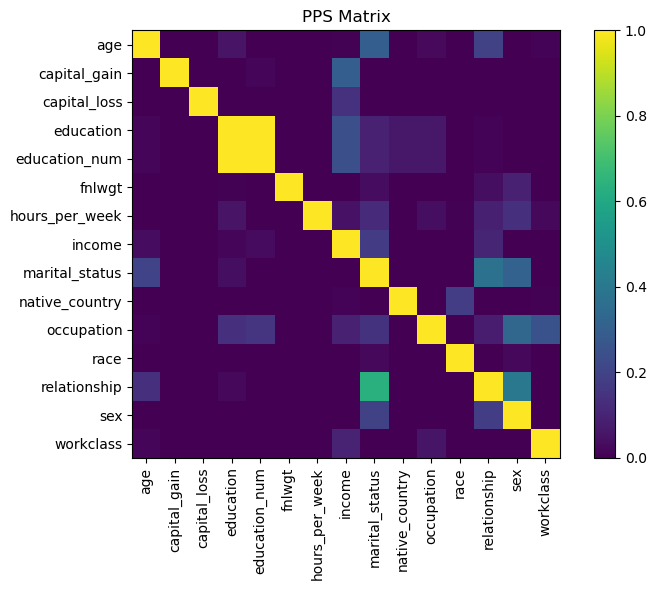

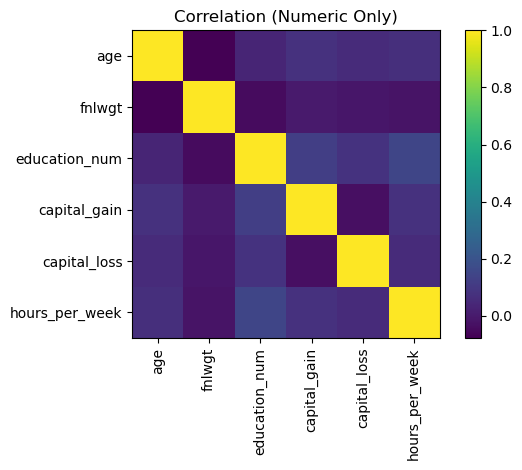

In [12]:
# Identify likely target
cands = [c for c in df.columns if c.lower() in ['income','class','target']]
target = cands[0] if cands else None
print("Target:", target)

if target is not None:
    pps_mat = pps.matrix(df_clean.dropna(subset=[target]))
    display(pps_mat.sort_values('ppscore', ascending=False).head(10))

    # Visual PPS heatmap
    pvt = pps_mat.pivot(index='x', columns='y', values='ppscore').fillna(0)
    plt.figure(figsize=(8,6))
    plt.imshow(pvt.values, interpolation='nearest')
    plt.title("PPS Matrix")
    plt.colorbar()
    plt.xticks(range(len(pvt.columns)), pvt.columns, rotation=90)
    plt.yticks(range(len(pvt.index)), pvt.index)
    plt.tight_layout()
    plt.show()

# Numeric correlation
if len(numeric_cols) >= 2:
    corr = df_clean[numeric_cols].corr()
    plt.figure()
    plt.imshow(corr.values, interpolation='nearest')
    plt.title("Correlation (Numeric Only)")
    plt.colorbar()
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.tight_layout()
    plt.show()

## 8) Conclusions
- **StandardScaler**: great for distance/dot-product models and PCA.
- **MinMaxScaler**: good for NN or bounded features.
- **One-Hot**: avoids false order, but can blow up columns; **Label-encoding** is compact but ordinal.
- **IsolationForest** helps remove outliers that can distort model training.
- **PPS** complements correlation by capturing non-linear & mixed-type predictive relationships.
